In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest
from matplotlib.colors import LinearSegmentedColormap

import scipy
from scipy import optimize, stats

import nilearn
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import pingouin as pg

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [4]:
dir_root = join('/mnt/ext6/GL/fmri_data')
dir_stat = join(dir_root, 'stats')
dir_mask = join(dir_root, 'masks')

In [5]:
list_subj = [
    'GL03', 'GL04', 'GL05', 'GL06', 'GL07'
    , 'GL08', 'GL09', 'GL10', 'GL11', 'GL12'
    , 'GL14', 'GL15', 'GL16', 'GL17', 'GL18'
    , 'GL19', 'GL20', 'GL21', 'GL22', 'GL24'
    , 'GL25', 'GL26', 'GL27', 'GL29'
]

In [6]:
bg_img = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

---

- Putamen

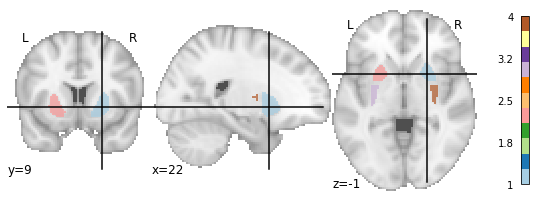

In [7]:
img_putamen = join(dir_mask, 'mask.putamen_4parts.nii')
nilearn.plotting.plot_roi(img_putamen, cmap='Paired', colorbar=True)

In [8]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_putamen, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['raPU', 'laPU', 'lpPU', 'rpPU']
)

In [9]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'Zscore'])

for subj in list_subj:
    ## reward
    img_Z = join(dir_stat, 'GLM.reward/%s/%s.reward.z_score_map.nii'%(subj,subj))
    Zs = masker.fit_transform(img_Z)[0]
    for roi, Z in zip(masker.labels, Zs):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'Zscore':Z}, ignore_index=True)
    ## move-stop
    img_Z = join(dir_stat, 'GLM.Move_Stop/%s.Move-Stop.z_score_map.nii'%subj)
    Zs = masker.fit_transform(img_Z)[0]
    for roi, Z in zip(masker.labels, Zs):
        df = df.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'Zscore':Z}, ignore_index=True)
        
### paired t-test
dt = pg.pairwise_tests(
    data=df
    , dv= 'Zscore'
    , subject='subj'
    , within=['source', 'ROI']
    , alpha=0.05
    , effsize='eta-square'
)
dt

,Contrast,source,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,eta-square
0,source,-,move-stop,reward,True,True,-3.914754,23.0,two-sided,6.950217e-04,48.272,0.285183
1,ROI,-,laPU,lpPU,True,True,-0.060299,23.0,two-sided,9.524382e-01,0.215,0.000015
2,ROI,-,laPU,raPU,True,True,2.189414,23.0,two-sided,3.897402e-02,1.585,0.007045
3,ROI,-,laPU,rpPU,True,True,3.863979,23.0,two-sided,7.881470e-04,43.218,0.073097
4,ROI,-,lpPU,raPU,True,True,1.250495,23.0,two-sided,2.236918e-01,0.429,0.008238
5,ROI,-,lpPU,rpPU,True,True,4.111591,23.0,two-sided,4.262601e-04,74.321,0.080020
6,ROI,-,raPU,rpPU,True,True,2.857118,23.0,two-sided,8.915397e-03,5.333,0.037177
7,source * ROI,move-stop,laPU,lpPU,True,True,-6.007448,23.0,two-sided,3.985113e-06,5029.739,0.127760
8,source * ROI,move-stop,laPU,raPU,True,True,3.892666,23.0,two-sided,7.341158e-04,46.003,0.015691
9,source * ROI,move-stop,laPU,rpPU,True,True,1.832215,23.0,two-sided,7.990011e-02,0.904,0.015527


In [17]:
# sagittals = []
# coronals = []
# for roi in df.ROI.values:
#     sagittal = 'left' if 'l'==roi[0] else ('right' if 'r'==roi[0] else 'invalid')
#     coronal = 'anterior' if 'a'==roi[1] else ('posterior' if 'p'==roi[1] else 'invalid')
    
#     sagittals.append(sagittal)
#     coronals.append(coronal)

# df['sagittal'] = sagittals
# df['coronal'] = coronals

# df

,subj,source,ROI,Zscore,sagittal,coronal
0,GL03,reward,raPU,2.237920,right,anterior
1,GL03,reward,laPU,1.873460,left,anterior
2,GL03,reward,lpPU,1.904778,left,posterior
3,GL03,reward,rpPU,2.618265,right,posterior
4,GL03,move-stop,raPU,0.930723,right,anterior
...,...,...,...,...,...,...
187,GL29,reward,rpPU,2.456721,right,posterior
188,GL29,move-stop,raPU,0.022380,right,anterior
189,GL29,move-stop,laPU,-0.256221,left,anterior
190,GL29,move-stop,lpPU,1.136425,left,posterior


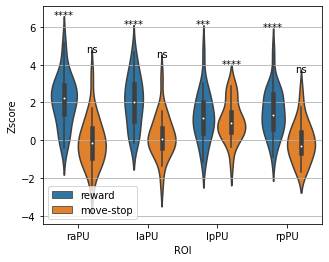

In [18]:
fig, ax = plt.subplots(figsize=(5,4))

ax = sns.violinplot(data=df, x='ROI', y='Zscore', hue='source', ax=ax)
ax.grid(axis='y')

y = ax.get_ylabel()
nhue=len(ax.get_legend_handles_labels()[-1])
for ii, text in enumerate(ax.get_xticklabels()):
    x = text.get_text()
    for jj, hue in enumerate(ax.get_legend_handles_labels()[-1]):
        kk = 2*(nhue*ii + jj)
        ## to represent asterisks above an each collection
        collection = ax.collections[kk]
        tmp = collection.get_paths()[0].vertices
        xmean, _ = tmp.mean(axis=0)
        _, ymax = tmp.max(axis=0)
        
        ## one sample t-test
        a = df[(df.source==hue)&(df.ROI==x)][y]
        tval, pval = stats.ttest_1samp(a,0)
        ax.text(xmean, ymax+0.05, convert_pvalue_to_asterisks(pval)
                , ha='center', va='center', size=10)
        
# ax.set(ylim=(-0.6,0.9))
ax.legend(loc='lower left')

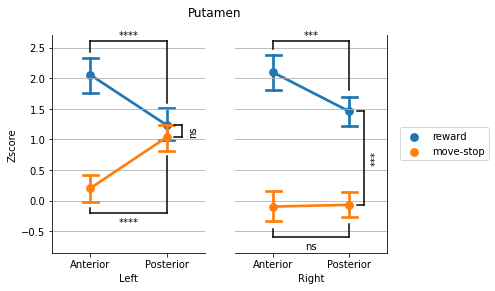

In [41]:
fig, axs = plt.subplots(ncols=2)
xlim = [-0.5, 1.5]
ylim = [-0.85, 2.7]
xApart, yApart = 0.1, 0.1

## Left
ax = sns.pointplot(
    data=df[(df.ROI=='laPU')|(df.ROI=='lpPU')], x='ROI', y='Zscore', hue='source'
    , capsize=0.2, ci=68
    , ax=axs[0]
)
ax.set_xlabel('Left')
ax.set_xticklabels(['Anterior','Posterior'])
ax.get_legend().remove()
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### paired t-test
a = df[(df.source=='move-stop')&(df.ROI=='lpPU')].Zscore
b = df[(df.source=='reward')&(df.ROI=='lpPU')].Zscore
tval, pval = stats.ttest_rel(a,b)
x = 1
xREdge = x + 0.2
ax.plot([x + xApart, xREdge], [a.mean(), a.mean()], 'k-')
ax.plot([x + xApart, xREdge], [b.mean(), b.mean()], 'k-')
ax.plot([xREdge, xREdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xREdge+xApart+0.05, 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.source=='reward')&(df.ROI=='laPU')].Zscore
b = df[(df.source=='reward')&(df.ROI=='lpPU')].Zscore
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 2.6
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.source=='move-stop')&(df.ROI=='laPU')].Zscore
b = df[(df.source=='move-stop')&(df.ROI=='lpPU')].Zscore
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.2
ax.plot([xL, xL], [a.mean()-a.sem()-yApart, yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-b.sem()-yApart, yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart+0.05), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

## Right
ax = sns.pointplot(
    data=df[(df.ROI=='raPU')|(df.ROI=='rpPU')], x='ROI', y='Zscore', hue='source'
    , capsize=0.2, ci=68
    , ax=axs[1]
)
ax.set_xlabel('Right')
ax.set_xticklabels(['Anterior','Posterior'])
ax.set_ylabel('')
ax.set_yticklabels('')
ax.tick_params(axis='y', direction='out', width=0)
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.legend(bbox_to_anchor=[1.7, .6])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

### paired t-test
a = df[(df.source=='move-stop')&(df.ROI=='rpPU')].Zscore
b = df[(df.source=='reward')&(df.ROI=='rpPU')].Zscore
tval, pval = stats.ttest_rel(a,b)
x = 1
xREdge = x + 0.2
ax.plot([x + xApart, xREdge], [a.mean(), a.mean()], 'k-')
ax.plot([x + xApart, xREdge], [b.mean(), b.mean()], 'k-')
ax.plot([xREdge, xREdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xREdge+xApart+0.05, 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.source=='reward')&(df.ROI=='raPU')].Zscore
b = df[(df.source=='reward')&(df.ROI=='rpPU')].Zscore
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 2.6
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.source=='move-stop')&(df.ROI=='raPU')].Zscore
b = df[(df.source=='move-stop')&(df.ROI=='rpPU')].Zscore
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.6
ax.plot([xL, xL], [a.mean()-a.sem()-yApart, yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-b.sem()-yApart, yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart+0.05), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

fig.suptitle('Putamen')
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.Putamen.pointplot.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

---

- Caudate

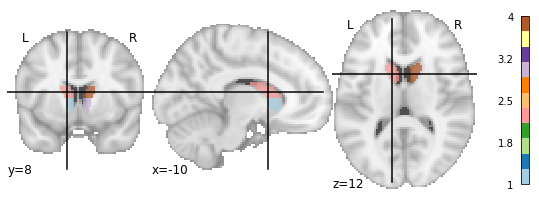

In [11]:
img_caudate = join(dir_mask, 'mask.caudate.nii')
nilearn.plotting.plot_roi(
    img_caudate
#     , cut_coords=(14, 5, 20)
    , cmap='Paired', colorbar=True
)

In [7]:
# tmp = nilearn.image.math_img(img1=img_caudate, formula='img1*0')
# tmp = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==4)')
# img_aCaudate = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==2)')

# tmp = nilearn.image.math_img(img1=img_caudate, formula='img1*0')
# tmp = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==3)')
# img_pCaudate = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==1)')

# img_caudate = nilearn.image.math_img(img1=img_aCaudate, img2=img_pCaudate, formula='img1+img2*2')

# nilearn.plotting.plot_roi(img_caudate)

# ## `3dmaskave` 와 결과 일치하는 것 확인함.
# masker = NiftiLabelsMasker(
#     labels_img=img_caudate, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
#     , labels=['anterior', 'posterior']
# )

In [8]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_caudate, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['lhCN', 'lbCN', 'rhCN', 'rbCN']
)

In [14]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'Zscore'])

for subj in list_subj:
    ## reward
    img_Z = join(dir_stat, 'GLM.reward/%s/%s.reward.z_score_map.nii'%(subj,subj))
    Zs = masker.fit_transform(img_Z)[0]
    for roi, Z in zip(masker.labels, Zs):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'Zscore':Z}, ignore_index=True)
    ## move-stop
    img_Z = join(dir_stat, 'GLM.Move_Stop/%s.Move-Stop.z_score_map.nii'%subj)
    Zs = masker.fit_transform(img_Z)[0]
    for roi, Z in zip(masker.labels, Zs):
        df = df.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'Zscore':Z}, ignore_index=True)

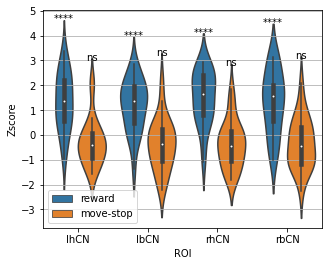

In [10]:
fig, ax = plt.subplots(figsize=(5,4))

ax = sns.violinplot(data=df, x='ROI', y='Zscore', hue='source', ax=ax)
ax.grid(axis='y')

y = ax.get_ylabel()
nhue=len(ax.get_legend_handles_labels()[-1])
for ii, text in enumerate(ax.get_xticklabels()):
    x = text.get_text()
    for jj, hue in enumerate(ax.get_legend_handles_labels()[-1]):
        kk = 2*(nhue*ii + jj)
        ## to represent asterisks above an each collection
        collection = ax.collections[kk]
        tmp = collection.get_paths()[0].vertices
        xmean, _ = tmp.mean(axis=0)
        _, ymax = tmp.max(axis=0)
        
        ## one sample t-test
        a = df[(df.source==hue)&(df.ROI==x)][y]
        tval, pval = stats.ttest_1samp(a,0)
        ax.text(xmean, ymax+0.05, convert_pvalue_to_asterisks(pval)
                , ha='center', va='center', size=10)
        
# ax.set(ylim=(-0.6,0.9))
ax.legend(loc='lower left')

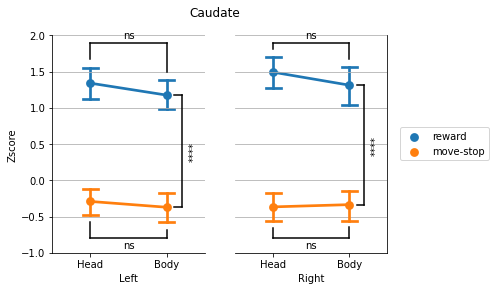

In [63]:
fig, axs = plt.subplots(ncols=2)
xlim = [-0.5, 1.5]
ylim = [-1.0, 2.0]
xApart, yApart = 0.1, 0.1

## Left
ax = sns.pointplot(
    data=df[(df.ROI=='lhCN')|(df.ROI=='lbCN')], x='ROI', y='Zscore', hue='source'
    , capsize=0.2, ci=68
    , ax=axs[0]
)
ax.set_xlabel('Left')
ax.set_xticklabels(['Head','Body'])
ax.get_legend().remove()
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### paired t-test
a = df[(df.source=='move-stop')&(df.ROI=='lbCN')].Zscore
b = df[(df.source=='reward')&(df.ROI=='lbCN')].Zscore
tval, pval = stats.ttest_rel(a,b)
x = 1
xREdge = x + 0.2
ax.plot([x + xApart, xREdge], [a.mean(), a.mean()], 'k-')
ax.plot([x + xApart, xREdge], [b.mean(), b.mean()], 'k-')
ax.plot([xREdge, xREdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xREdge+xApart+0.05, 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.source=='reward')&(df.ROI=='lhCN')].Zscore
b = df[(df.source=='reward')&(df.ROI=='lbCN')].Zscore
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 1.9
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.source=='move-stop')&(df.ROI=='lhCN')].Zscore
b = df[(df.source=='move-stop')&(df.ROI=='lbCN')].Zscore
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.8
ax.plot([xL, xL], [a.mean()-a.sem()-yApart, yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-b.sem()-yApart, yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

## Right
ax = sns.pointplot(
    data=df[(df.ROI=='rhCN')|(df.ROI=='rbCN')], x='ROI', y='Zscore', hue='source'
    , capsize=0.2, ci=68
    , ax=axs[1]
)
ax.set_xlabel('Right')
ax.set_xticklabels(['Head','Body'])
ax.set_ylabel('')
ax.set_yticklabels('')
ax.tick_params(axis='y', direction='out', width=0)
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.legend(bbox_to_anchor=[1.7, .6])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

### paired t-test
a = df[(df.source=='move-stop')&(df.ROI=='rbCN')].Zscore
b = df[(df.source=='reward')&(df.ROI=='rbCN')].Zscore
tval, pval = stats.ttest_rel(a,b)
x = 1
xREdge = x + 0.2
ax.plot([x + xApart, xREdge], [a.mean(), a.mean()], 'k-')
ax.plot([x + xApart, xREdge], [b.mean(), b.mean()], 'k-')
ax.plot([xREdge, xREdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xREdge+xApart+0.05, 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.source=='reward')&(df.ROI=='rhCN')].Zscore
b = df[(df.source=='reward')&(df.ROI=='rbCN')].Zscore
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 1.9
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.source=='move-stop')&(df.ROI=='rhCN')].Zscore
b = df[(df.source=='move-stop')&(df.ROI=='rbCN')].Zscore
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.8
ax.plot([xL, xL], [a.mean()-a.sem()-yApart, yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-b.sem()-yApart, yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

fig.suptitle('Caudate')
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.Caudate.pointplot.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

---

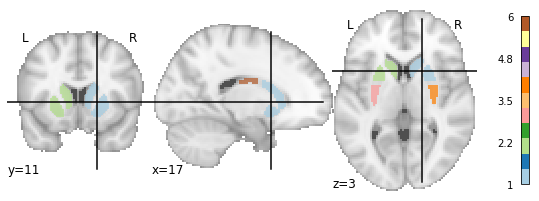

In [64]:
img_striatum = join(dir_mask, 'mask.striatum_6parts.nii')
nilearn.plotting.plot_roi(img_striatum, cmap='Paired', colorbar=True)

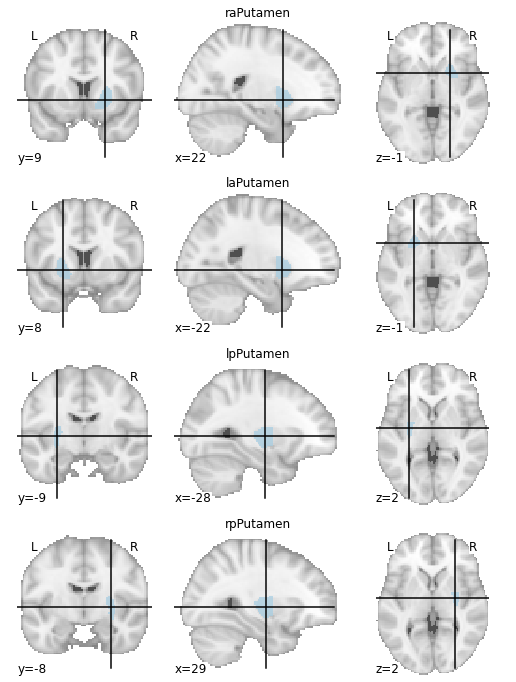

In [14]:
labels = ['raPutamen', 'laPutamen', 'lpPutamen', 'rpPutamen']

fig, axs = plt.subplots(nrows=len(labels), figsize=(9,12))
for ii, label in enumerate(labels):
    ax = axs[ii]
    tmp = nilearn.image.math_img(img1=img_putamen, formula='img1==%d'%(ii+1))
    nilearn.plotting.plot_roi(tmp, cmap='Paired', axes=ax)
    ax.set_title(label)

# fig.tight_layout()

---

In [15]:
dh = pd.DataFrame(columns=['subj', 'source', 'ROI', 't'])
dh

,subj,source,ROI,t


- Putamen

In [16]:
tmp = nilearn.image.math_img(img1=img_putamen, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_putamen, formula='img1+(img2==1)')
img_aPutamen = nilearn.image.math_img(img1=tmp, img2=img_putamen, formula='img1+(img2==2)')

tmp = nilearn.image.math_img(img1=img_putamen, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_putamen, formula='img1+(img2==3)')
img_pPutamen = nilearn.image.math_img(img1=tmp, img2=img_putamen, formula='img1+(img2==4)')

img_Putamen = nilearn.image.math_img(img1=img_aPutamen, img2=img_pPutamen, formula='img1+img2*2')

In [17]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_Putamen, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['aPutamen', 'pPutamen']
)

In [18]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 't'])

for ii, subj in enumerate(list_subj):
    ## reward
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'beta':beta}, ignore_index=True)
    ## Move-Stop
    img_beta = join(dir_stat, 'GLM.Move_Stop/statMove.%s.Move-Stop_GLT#0_Coef.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'beta':beta}, ignore_index=True)

dh = dh.append(df)
df

,subj,source,ROI,t,beta
0,GL03,reward,aPutamen,NaN,0.292649
1,GL03,reward,pPutamen,NaN,0.283536
2,GL03,move-stop,aPutamen,NaN,0.054021
3,GL03,move-stop,pPutamen,NaN,0.060376
4,GL04,reward,aPutamen,NaN,0.130735
...,...,...,...,...,...
91,GL27,move-stop,pPutamen,NaN,-0.074127
92,GL29,reward,aPutamen,NaN,0.492906
93,GL29,reward,pPutamen,NaN,0.400000
94,GL29,move-stop,aPutamen,NaN,-0.004101


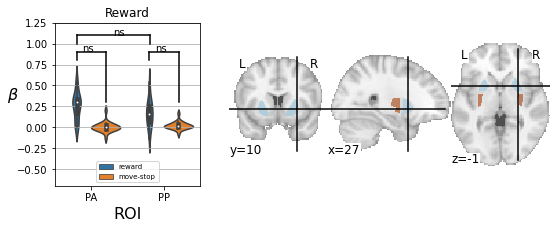

In [20]:
fig = plt.figure(figsize=(12, 3), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=4)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1:3]))

ax = axs[0]
ax = sns.violinplot(
    data=df, x='ROI', y='beta', hue='source'
    , ci='sd', capsize=.3
    , ax=ax
)
ax.set(title='Reward')
ax.legend(loc='lower center', fontsize=7)
ax.set_ylabel(r'$\beta$', rotation=0, fontsize=16)
ax.set_ylim([-.7,1.25])
ax.set_xlabel('ROI', fontsize=16)
ax.set_xlim([-.5, 1.5])
ax.set_xticklabels(['PA', 'PP'])
ax.grid(axis='y')

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aPutamen')].t
b = df[(df.source=='reward')&(df.ROI=='pPutamen')].t
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[1.,1.1], 'k-')
ax.plot([.81,.81],[1.,1.1], 'k-')
ax.plot([-.2,.81],[1.1,1.1], 'k-')
ax.text(.3,1.1, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aPutamen')].t
b = df[(df.source=='move-stop')&(df.ROI=='aPutamen')].t
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[.8,.9], 'k-')
ax.plot([.2,.2],[.3,.9], 'k-')
ax.plot([-.2,.2],[.9,.9], 'k-')
ax.text(-.125,.9, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='pPutamen')].t
b = df[(df.source=='move-stop')&(df.ROI=='pPutamen')].t
tval, pval = stats.ttest_ind(a,b)

ax.plot([.8,.8],[.8,.9], 'k-')
ax.plot([1.205,1.205],[.3,.9], 'k-')
ax.plot([.8,1.205],[.9,.9], 'k-')
ax.text(.875,.9, convert_pvalue_to_asterisks(pval))

# fig.tight_layout()
ax = axs[1]
nilearn.plotting.plot_roi(img_Putamen, cmap='Paired', cut_coords=(27,10,-1), axes=ax)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.putamen.violinplot.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

- Caudate

In [21]:
tmp = nilearn.image.math_img(img1=img_caudate, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==1)')
img_aCaudate = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==2)')

tmp = nilearn.image.math_img(img1=img_caudate, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==3)')
img_pCaudate = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2==4)')

img_Caudate = nilearn.image.math_img(img1=img_aCaudate, img2=img_pCaudate, formula='img1+img2*2')

In [22]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_Caudate, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['aCaudate', 'pCaudate']
)

In [23]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

for ii, subj in enumerate(list_subj):
    ## reward
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'beta':beta}, ignore_index=True)
    ## Move-Stop
    img_beta = join(dir_stat, 'GLM.Move_Stop/statMove.%s.Move-Stop_GLT#0_Coef.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'beta':beta}, ignore_index=True)

dh = dh.append(df)
df

,subj,source,ROI,beta
0,GL03,reward,aCaudate,0.299908
1,GL03,reward,pCaudate,0.430838
2,GL03,move-stop,aCaudate,0.031746
3,GL03,move-stop,pCaudate,0.035592
4,GL04,reward,aCaudate,0.073800
...,...,...,...,...
91,GL27,move-stop,pCaudate,-0.029589
92,GL29,reward,aCaudate,0.274921
93,GL29,reward,pCaudate,0.184790
94,GL29,move-stop,aCaudate,-0.005161


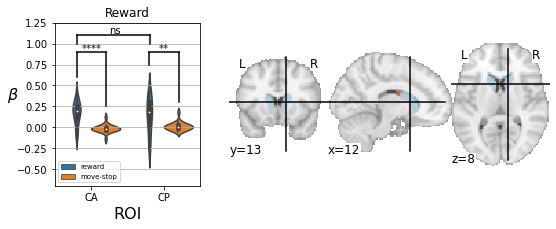

In [27]:
fig = plt.figure(figsize=(12, 3), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=4)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1:3]))

ax = axs[0]
ax = sns.violinplot(
    data=df, x='ROI', y='beta', hue='source'
    , ci='sd', capsize=.3
    , ax=ax
)
ax.set(title='Reward')
ax.legend(loc='lower left', fontsize=7)
ax.set_ylabel(r'$\beta$', rotation=0, fontsize=16)
ax.set_ylim([-.7,1.25])
ax.set_xlabel('ROI', fontsize=16)
ax.set_xlim([-.5, 1.5])
ax.set_xticklabels(['CA', 'CP'])
ax.grid(axis='y')

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aCaudate')].beta
b = df[(df.source=='reward')&(df.ROI=='pCaudate')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[1.,1.1], 'k-')
ax.plot([.81,.81],[1.,1.1], 'k-')
ax.plot([-.2,.81],[1.1,1.1], 'k-')
ax.text(.25,1.125, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aCaudate')].beta
b = df[(df.source=='move-stop')&(df.ROI=='aCaudate')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[.6,.9], 'k-')
ax.plot([.2,.2],[.25,.9], 'k-')
ax.plot([-.2,.2],[.9,.9], 'k-')
ax.text(-.125,.9, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='pCaudate')].beta
b = df[(df.source=='move-stop')&(df.ROI=='pCaudate')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([.8,.8],[.75,.9], 'k-')
ax.plot([1.205,1.205],[.3,.9], 'k-')
ax.plot([.8,1.205],[.9,.9], 'k-')
ax.text(.925,.9, convert_pvalue_to_asterisks(pval))

# fig.tight_layout()
ax = axs[1]
nilearn.plotting.plot_roi(img_Caudate, cmap='Paired', cut_coords=(12,13,8), axes=ax)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.caudate.violinplot.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

- Striatum

In [28]:
tmp = nilearn.image.math_img(img1=img_striatum, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==1)')
img_aStriatum = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==2)')

tmp = nilearn.image.math_img(img1=img_striatum, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==3)')
tmp = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==4)')
tmp = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==5)')
img_pStriatum = nilearn.image.math_img(img1=tmp, img2=img_striatum, formula='img1+(img2==6)')

img_Striatum = nilearn.image.math_img(img1=img_aStriatum, img2=img_pStriatum, formula='img1+img2*2')

In [29]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_Striatum, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['aStriatum', 'pStriatum']
)

In [30]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

for ii, subj in enumerate(list_subj):
    ## reward
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'beta':beta}, ignore_index=True)
    ## Move-Stop
    img_beta = join(dir_stat, 'GLM.Move_Stop/statMove.%s.Move-Stop_GLT#0_Coef.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'beta':beta}, ignore_index=True)

dh = dh.append(df)
df

,subj,source,ROI,beta
0,GL03,reward,aStriatum,0.296272
1,GL03,reward,pStriatum,0.306897
2,GL03,move-stop,aStriatum,0.042904
3,GL03,move-stop,pStriatum,0.056445
4,GL04,reward,aStriatum,0.102320
...,...,...,...,...
91,GL27,move-stop,pStriatum,-0.067063
92,GL29,reward,aStriatum,0.384113
93,GL29,reward,pStriatum,0.365870
94,GL29,move-stop,aStriatum,-0.004630


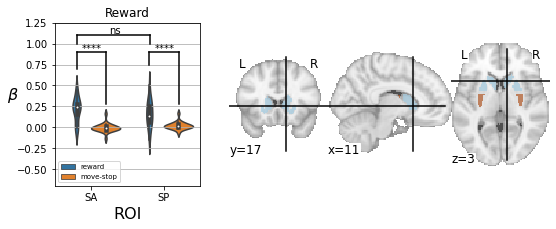

In [37]:
fig = plt.figure(figsize=(12, 3), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=4)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1:3]))

ax = axs[0]
ax = sns.violinplot(
    data=df, x='ROI', y='beta', hue='source'
    , ci='sd', capsize=.3
    , ax=ax
)
ax.set(title='Reward')
ax.legend(loc='lower left', fontsize=7)
ax.set_ylabel(r'$\beta$', rotation=0, fontsize=16)
ax.set_ylim([-.7,1.25])
ax.set_xlabel('ROI', fontsize=16)
ax.set_xlim([-.5, 1.5])
ax.set_xticklabels(['SA', 'SP'])
ax.grid(axis='y')

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aStriatum')].beta
b = df[(df.source=='reward')&(df.ROI=='pStriatum')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[1.,1.1], 'k-')
ax.plot([.81,.81],[1.,1.1], 'k-')
ax.plot([-.2,.81],[1.1,1.1], 'k-')
ax.text(.25,1.125, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='aStriatum')].beta
b = df[(df.source=='move-stop')&(df.ROI=='aStriatum')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([-.2,-.2],[.7,.9], 'k-')
ax.plot([.2,.2],[.28,.9], 'k-')
ax.plot([-.2,.2],[.9,.9], 'k-')
ax.text(-.125,.9, convert_pvalue_to_asterisks(pval))

## t-test #1
a = df[(df.source=='reward')&(df.ROI=='pStriatum')].beta
b = df[(df.source=='move-stop')&(df.ROI=='pStriatum')].beta
tval, pval = stats.ttest_ind(a,b)

ax.plot([.8,.8],[.74,.9], 'k-')
ax.plot([1.205,1.205],[.28,.9], 'k-')
ax.plot([.8,1.205],[.9,.9], 'k-')
ax.text(.875,.9, convert_pvalue_to_asterisks(pval))

# fig.tight_layout()
ax = axs[1]
nilearn.plotting.plot_roi(img_Striatum, cmap='Paired', cut_coords=(11,17,3), axes=ax)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.striatum.violinplot.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

---

In [38]:
dh

,subj,source,ROI,beta
0,GL03,reward,aPutamen,0.292649
1,GL03,reward,pPutamen,0.283536
2,GL03,move-stop,aPutamen,0.054021
3,GL03,move-stop,pPutamen,0.060376
4,GL04,reward,aPutamen,0.130735
...,...,...,...,...
91,GL27,move-stop,pStriatum,-0.067063
92,GL29,reward,aStriatum,0.384113
93,GL29,reward,pStriatum,0.365870
94,GL29,move-stop,aStriatum,-0.004630


Text(0.5, 0, 'ROI')

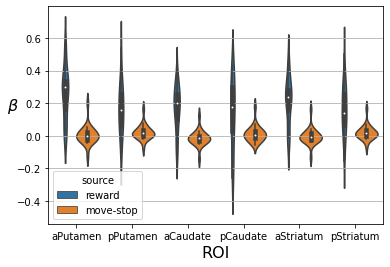

In [46]:
fig, ax = plt.subplots()

ax = sns.violinplot(
    data=dh, x='ROI', y='beta', hue='source'
    , ci='sd', capsize=.3
    , ax=ax
)
ax.grid(axis='y')
ax.set_ylabel(r'$\beta$', rotation=0, fontsize=16)
ax.set_xlabel('ROI', fontsize=16)

In [41]:
rm_anova(
    data=dh
    , dv= 'beta'
    , subject='subj'
    , within=['source','ROI']
    , effsize='np2'
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,source,2.344453,1,23,2.344453,32.044786,9.198834e-06,0.000009,0.582158,1.000000
1,ROI,0.100660,5,115,0.020132,7.167242,7.158991e-06,0.001358,0.237584,0.438021
2,source * ROI,0.146725,5,115,0.029345,9.650566,1.029781e-07,0.000393,0.295571,0.384081


---

In [11]:
img_putamen = join(dir_mask, 'mask.putamen.nii')
img_caudate = join(dir_mask, 'mask.caudate.nii')
img_NAc = join(dir_mask, 'mask.NAc.nii')

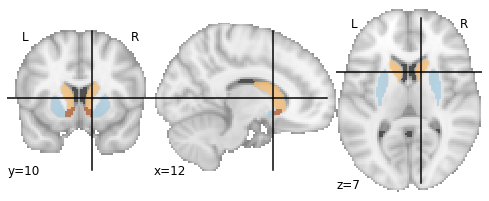

In [12]:
tmp = nilearn.image.math_img(img1=img_putamen, formula='img1*0')
tmp = nilearn.image.math_img(img1=tmp, img2=img_putamen, formula='img1+img2')
tmp = nilearn.image.math_img(img1=tmp, img2=img_caudate, formula='img1+(img2*2)')
img_roi = nilearn.image.math_img(img1=tmp, img2=img_NAc, formula='img1+(img2*3)')
nilearn.plotting.plot_roi(img_roi, cmap='Paired')

In [13]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_roi, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['putamen', 'caudate', 'NAc']
)

In [14]:
dh = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

In [15]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])
dg = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

for ii, subj in enumerate(list_subj):
    ## reward
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'beta':beta}, ignore_index=True)
    ## Move-Stop
    img_beta = join(dir_stat, 'GLM.Move_Stop/statMove.%s.Move-Stop_GLT#0_Coef.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        dg = dg.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'beta':beta}, ignore_index=True)

dh = dh.append(df)
dh = dh.append(dg)
dh

,subj,source,ROI,beta
0,GL03,reward,putamen,0.296809
1,GL03,reward,caudate,0.320167
2,GL03,reward,NAc,0.113360
3,GL04,reward,putamen,0.071883
4,GL04,reward,caudate,0.041950
...,...,...,...,...
67,GL27,move-stop,caudate,-0.124015
68,GL27,move-stop,NAc,-0.050740
69,GL29,move-stop,putamen,0.011313
70,GL29,move-stop,caudate,-0.003814


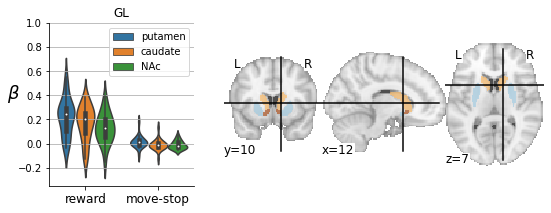

In [16]:
fig = plt.figure(figsize=(12, 3), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=4)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1:3]))

ax = axs[0]
ax = sns.violinplot(
    data=dh, x='source', y='beta'
    , hue='ROI'
    , ci='sd', capsize=.3
    , ax=ax
)

# ## t-test #1
# a = df[(df.source=='reward')&(df.ROI=='putamen')].beta
# b = df[(df.source=='reward')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_ind(a,b)
# ax.plot([-.2,-.2],[.8,.86], 'k-')
# ax.plot([.2,.2],[.62,.86], 'k-')
# ax.plot([-.2,.2],[.86,.86], 'k-')
# ax.text(-.04,.89, convert_pvalue_to_asterisks(pval))

# ## t-test #2
# a = df[(df.source=='reward')&(df.ROI=='putamen')].beta
# tval, pval = stats.ttest_1samp(a, popmean=0)
# ax.text(-.33, .72, convert_pvalue_to_asterisks(pval))
# b = df[(df.source=='reward')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_1samp(b, popmean=0)
# ax.text(.07, .54, convert_pvalue_to_asterisks(pval))

# ## t-test #3
# a = df[(df.source=='move-stop')&(df.ROI=='putamen')].beta
# b = df[(df.source=='move-stop')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_ind(a,b)
# ax.plot([.8,.8],[.35,.38], 'k-')
# ax.plot([1.2,1.2],[.29,.38], 'k-')
# ax.plot([.8,1.2],[.38,.38], 'k-')
# ax.text(.95,.41, convert_pvalue_to_asterisks(pval))

# ## t-test #2
# a = df[(df.source=='move-stop')&(df.ROI=='putamen')].beta
# tval, pval = stats.ttest_1samp(a, popmean=0)
# ax.text(.72, .27, convert_pvalue_to_asterisks(pval))
# b = df[(df.source=='move-stop')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_1samp(b, popmean=0)
# ax.text(1.12, .21, convert_pvalue_to_asterisks(pval))

ax.set(ylim=(-.35, 1.))
ax.grid(axis='y')
ax.legend()
ax.set_ylabel(r'$\beta$', fontsize=18, rotation=0)
ax.set_xlabel('', fontsize=0)
ax.set_xticklabels(['reward', 'move-stop'], fontsize=12)
ax.set_title('GL')

sns.despine()

ax = axs[1]
nilearn.plotting.plot_roi(img_roi, cmap='Paired', axes=ax)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.striatum.violinplot.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

In [35]:
stats.ttest_1samp(df[df.ROI=='NAc'].beta, popmean=0.)

Ttest_1sampResult(statistic=5.081780375804688, pvalue=3.8091091737493394e-05)

In [36]:
a = df[df.ROI=='putamen'].beta
b = df[df.ROI=='NAc'].beta
stats.ttest_ind(a,b)

Ttest_indResult(statistic=2.287368406790266, pvalue=0.026822175479694017)

---

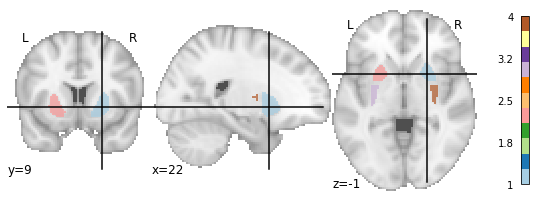

In [7]:
img_putamen = join(dir_mask, 'mask.putamen_4parts.nii')
nilearn.plotting.plot_roi(img_putamen, cmap='Paired', colorbar=True)

In [8]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_putamen, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['raPU', 'laPU', 'lpPU', 'rpPU']
)

In [9]:
df = pd.DataFrame(columns=['subj', 'condition', 'ROI', 'AP', 'LR', 'beta'])
df

,subj,condition,ROI,AP,LR,beta


In [10]:
for subj in list_subj:
    ## reward
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'a' in label else ('posterior' if 'p' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'reward', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
    ## move-stop
    img_beta = join(dir_stat, 'GLM.Move_Stop/%s.Move-Stop_GLT#0_Coef.tlrc.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'a' in label else ('posterior' if 'p' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'move-stop', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )

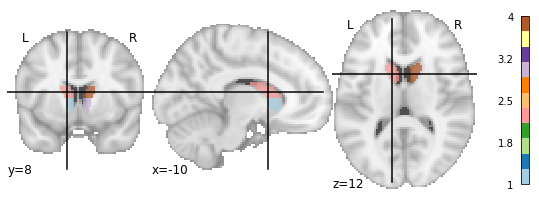

In [11]:
img_caudate = join(dir_mask, 'mask.caudate.nii')
nilearn.plotting.plot_roi(img_caudate, cmap='Paired', colorbar=True)

In [12]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_caudate, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['lhCN', 'lbCN', 'rhCN', 'rbCN']
)

In [13]:
for subj in list_subj:
    ## reward
    img_beta = join(dir_stat, 'GLM.reward/%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'h' in label else ('posterior' if 'b' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'reward', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
    ## move-stop
    img_beta = join(dir_stat, 'GLM.Move_Stop/%s.Move-Stop_GLT#0_Coef.tlrc.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'h' in label else ('posterior' if 'b' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'move-stop', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )

In [14]:
df

,subj,condition,ROI,AP,LR,beta
0,GL03,reward,putamen,anterior,right,0.299540
1,GL03,reward,putamen,anterior,left,0.285054
2,GL03,reward,putamen,posterior,left,0.252369
3,GL03,reward,putamen,posterior,right,0.317310
4,GL03,move-stop,putamen,anterior,right,0.037952
...,...,...,...,...,...,...
379,GL29,reward,caudate,posterior,right,0.264964
380,GL29,move-stop,caudate,anterior,left,-0.024600
381,GL29,move-stop,caudate,posterior,left,-0.025971
382,GL29,move-stop,caudate,anterior,right,-0.016057


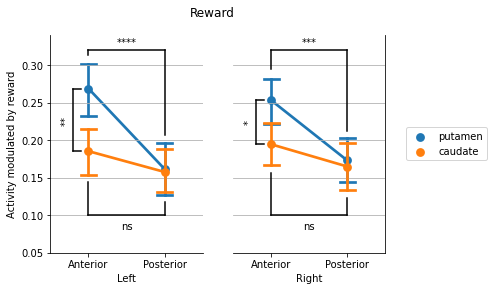

In [97]:
fig, axs = plt.subplots(ncols=2)
xlim = [-0.5, 1.5]
xticks = ['Anterior','Posterior']
ylim = [0.05, 0.34]
ylabel = 'Activity modulated by reward'
xApart, yApart = 0.1, 0.01

## Left
ax = sns.pointplot(
    data=df[(df.condition=='reward')&(df.LR=='left')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[0]
)
ax.set_xlabel('Left')
ax.set_ylabel(ylabel)
ax.set_xticklabels(xticks)
ax.get_legend().remove()
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### paired t-test
a = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.2
ax.plot([x - xApart, xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - xApart, xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.32
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = 0.1
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart+0.005), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

## Right
ax = sns.pointplot(
    data=df[(df.condition=='reward')&(df.LR=='right')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[1]
)
ax.set_xlabel('Right')
ax.set_xticklabels(xticks)
ax.set_ylabel('')
ax.set_yticklabels('')
ax.tick_params(axis='y', direction='out', width=0)
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.legend(bbox_to_anchor=[1.7, .6])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

### paired t-test
a = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.2
ax.plot([x - xApart, xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - xApart, xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.32
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = 0.1
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart+0.005), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

fig.suptitle('Reward')
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.pointplot.reward.beta.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

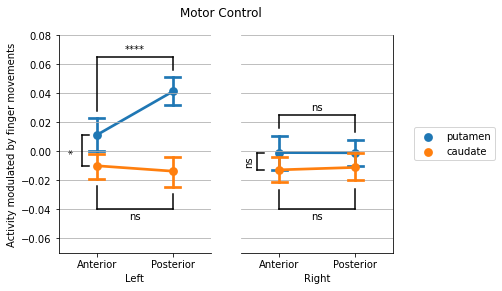

In [100]:
fig, axs = plt.subplots(ncols=2)
xlim = [-0.5, 1.5]
xticks = ['Anterior','Posterior']
ylim = [-0.07, 0.08]
ylabel = 'Activity modulated by finger movements'
xApart, yApart = 0.1, 0.005

## Left
ax = sns.pointplot(
    data=df[(df.condition=='move-stop')&(df.LR=='left')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[0]
)
ax.set_xlabel('Left')
ax.set_ylabel(ylabel)
ax.set_xticklabels(xticks)
ax.get_legend().remove()
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### paired t-test
a = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.2
ax.plot([x - xApart, xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - xApart, xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.065
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.04
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

## Right
ax = sns.pointplot(
    data=df[(df.condition=='move-stop')&(df.LR=='right')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[1]
)
ax.set_xlabel('Right')
ax.set_xticklabels(xticks)
ax.set_ylabel('')
ax.set_yticklabels('')
ax.tick_params(axis='y', direction='out', width=0)
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.legend(bbox_to_anchor=[1.7, .6])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

### paired t-test
a = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.3
ax.plot([x - (xApart+0.1), xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - (xApart+0.1), xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.025
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.04
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

fig.suptitle('Motor Control')
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/GL.GLM.pointplot.move-stop.beta.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

---

In [7]:
threshold = 3.291 # This is a z-score for p=0.001

In [12]:
zscore_reward = join('/mnt/ext6/GL/fmri_data/stats/GLM.reward/GL.reward.group.Zscore.n24.nii')
zscore_motor = join('/mnt/ext6/GL/fmri_data/stats/GLM.Move_Stop/GL.move-stop.group.Zscore.n24.nii')

In [14]:
tmp = nilearn.image.math_img(
    img1=zscore_reward, img2=zscore_motor
    , formula='img1*(img1>%f) - img2*(img2>%f)'%(threshold, threshold)
)


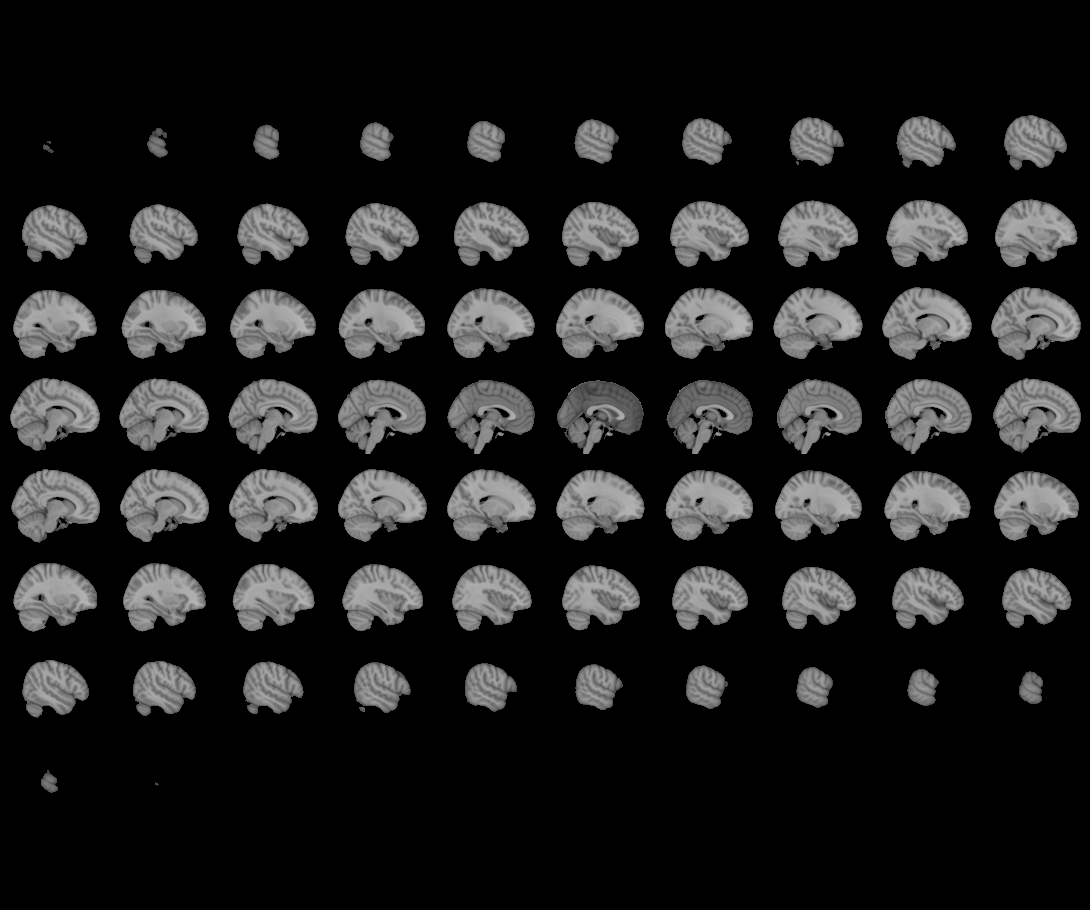
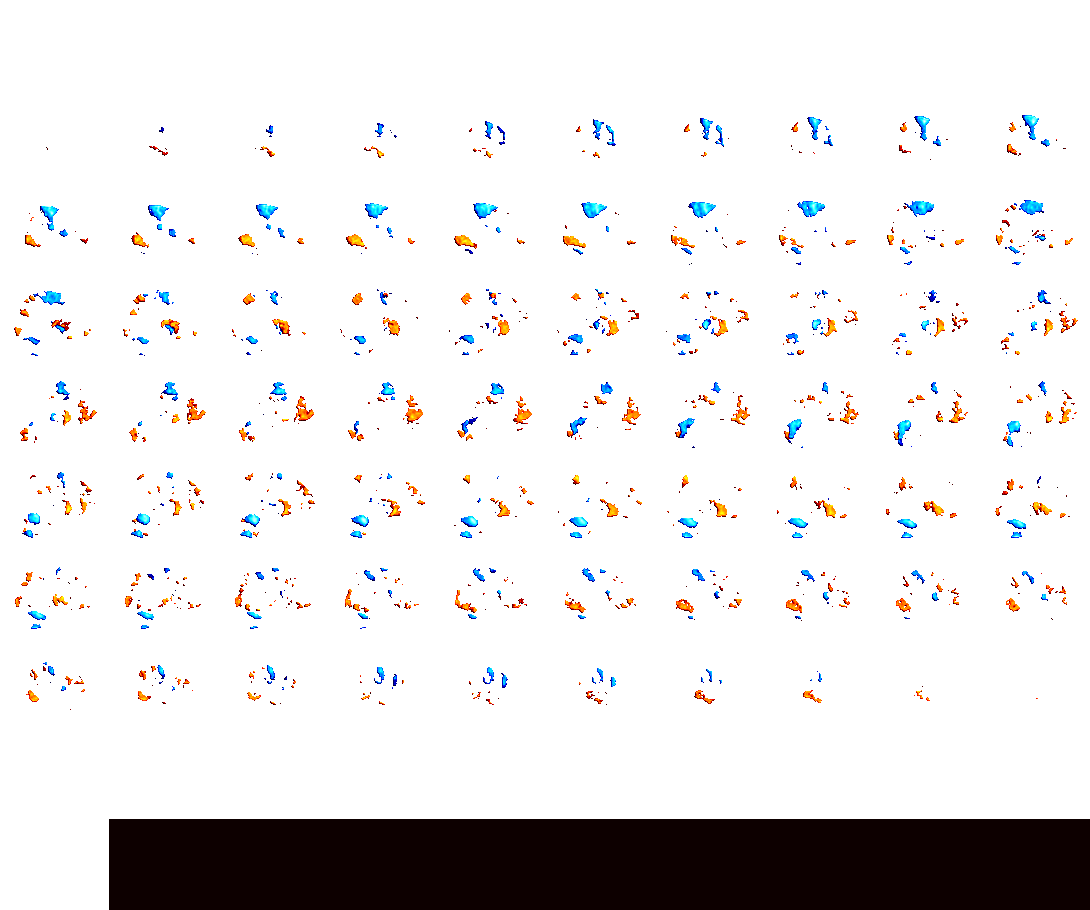

In [16]:
nilearn.plotting.view_img(tmp)

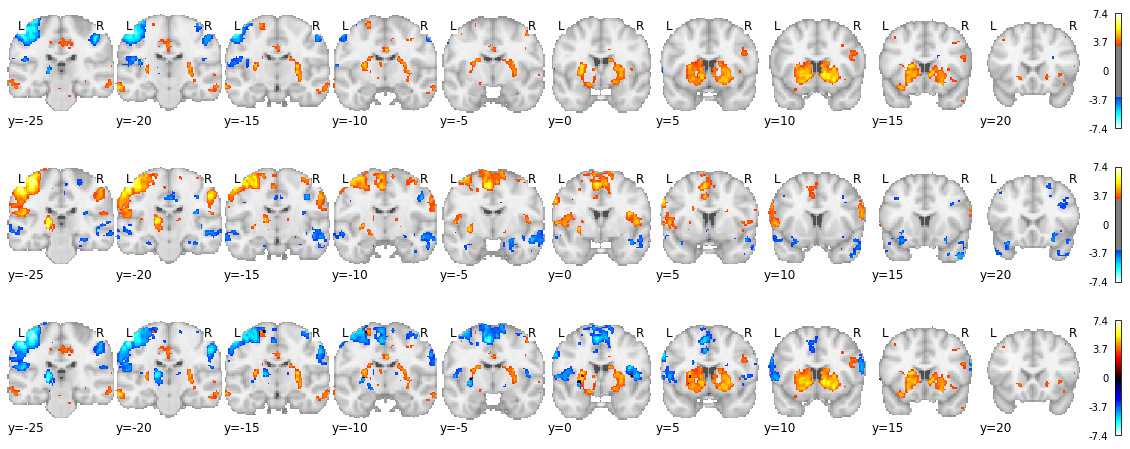

In [19]:
fig, axs = plt.subplots(nrows=3, figsize=(20, 8))

cut_coords = range(-25,21,5)
vmax = 7.4
axis = 'y'
cmap=nilearn_cmaps['cold_hot']

nilearn.plotting.plot_stat_map(
    zscore_reward
    , threshold=threshold
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=axs[0]
)

nilearn.plotting.plot_stat_map(
    zscore_motor
    , threshold=threshold
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=axs[1]
)

nilearn.plotting.plot_stat_map(
    tmp
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=axs[2]
)

# fig.tight_layout()

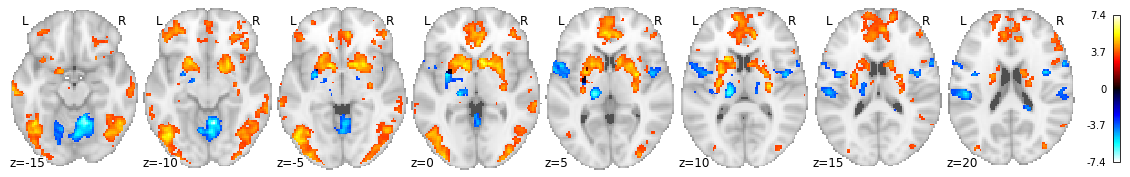

In [17]:
fig, ax = plt.subplots(figsize=(20, 3))

cut_coords = range(-15,21,5)
vmax = 7.4
axis = 'z'
cmap=nilearn_cmaps['cold_hot']

nilearn.plotting.plot_stat_map(
    tmp
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=ax
)

# fig.tight_layout()

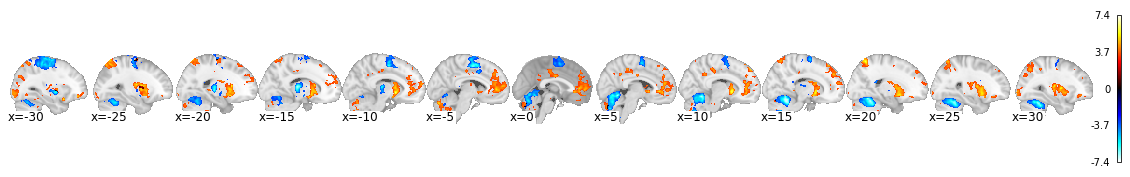

In [18]:
fig, ax = plt.subplots(figsize=(20, 3))

cut_coords = range(-30,31,5)
vmax = 7.4
axis = 'x'
cmap=nilearn_cmaps['cold_hot']

nilearn.plotting.plot_stat_map(
    tmp
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=ax
)

# fig.tight_layout()